In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch.unitroot import ADF, PhillipsPerron, DFGLS
from arch import arch_model
from pmdarima.arima import auto_arima
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

ModuleNotFoundError: No module named 'arch'

# 1. ​​Create​​ a ​​multivariate​​ time ​​series; ​​perform ​​any ​​interpolations.​​​​

In [ ]:
gss = pd.read_csv("trends-gss.csv")
variables = ["year", "progunlaw", "age", "hapmar", "degree", "realinc"]
sub = gss[variables].copy()

In [3]:
sub['nprogunlaw'] = np.where(sub['progunlaw'] == 1, 1, 0)
sub['baplus'] = np.where(sub['degree'] >= 3, 1, 0)
sub['happinessmar'] = np.where(sub['hapmar'] == 1, 1, 0)
sub['income'] = sub['realinc']

In [4]:
by_year = sub.groupby('year', as_index = False).agg('mean').replace({0.000000: np.nan})

In [5]:
add_years_df = pd.DataFrame(data = pd.Series([1979, 1981, 1992, 1995] + list(np.arange(1997, 2009, 2))),
                            columns = ['year'])
                            
by_year = pd.concat([by_year, add_years_df], sort = False, ignore_index = True)

In [6]:
by_year = by_year.sort_values('year')
by_year = by_year.set_index("year", drop = False)
by_year_ts = by_year.interpolate(method = 'linear')

In [7]:
by_year_ts['progunlaw_pct'] = by_year_ts['progunlaw']*100
by_year_ts['ba_pct'] = by_year_ts['baplus']*100
by_year_ts['hapmar_pct'] = by_year_ts['happinessmar']*100

# 2.​​ Graph ​​the​​ relationships ​​between ​​X​​ and​​ Y. Explain how you think Y should relate to your key Xs.

In [8]:
corr_vars = ['progunlaw_pct', 'hapmar_pct', 'ba_pct', 'age', 'income', 'year']
by_year_ts[corr_vars].corr()

,gunlaw_pct,hapmar_pct,ba_pct,age,income,year
gunlaw_pct,1.000000,0.549366,-0.658677,-0.371104,-0.427310,-0.607751
hapmar_pct,0.549366,1.000000,-0.824718,-0.638864,-0.614885,-0.853999
ba_pct,-0.658677,-0.824718,1.000000,0.812950,0.676960,0.977415
age,-0.371104,-0.638864,0.812950,1.000000,0.532060,0.859790
income,-0.427310,-0.614885,0.676960,0.532060,1.000000,0.635920
year,-0.607751,-0.853999,0.977415,0.859790,0.635920,1.000000


<AxesSubplot:>

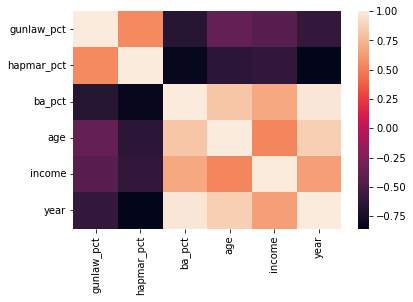

In [9]:
sns.heatmap(by_year_ts[corr_vars].corr())

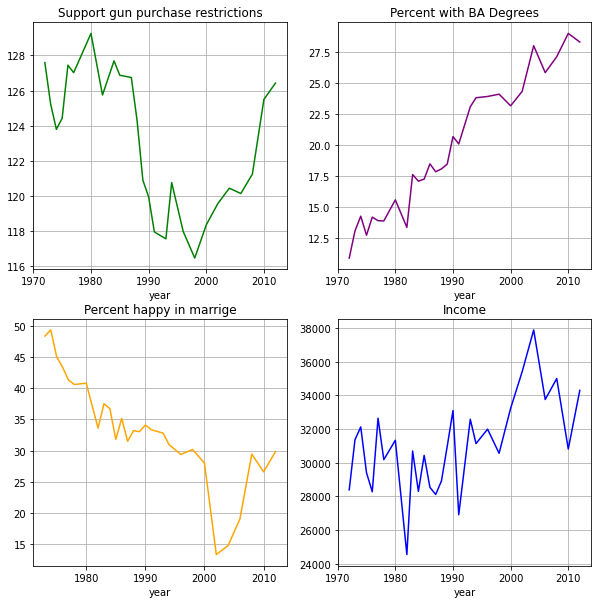

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

by_year_ts['progunlaw_pct'].plot(title = 'Support gun purchase restrictions', color = 'g', ax = axes[0,0], grid = True)
by_year_ts['ba_pct'].plot(title = 'Percent with BA Degrees', color = 'purple', ax = axes[0,1], grid = True)
by_year_ts['hapmar_pct'].plot(title = 'Percent happy in marrige', color = 'orange', ax = axes[1,0], grid = True)
by_year_ts['income'].plot(title = 'Income', color = 'b', ax = axes[1,1], grid = True)

plt.show()

# 3. ​​Run ​​a ​​simple ​​time​ ​series ​​regression, ​​with ​​one ​​X ​​and ​​no ​​trend. ​​​​Interpret ​​it.​​​​

In [11]:
lm_progunlaw = smf.ols('progunlaw_pct ~ ba_pct', data = by_year_ts).fit()
lm_progunlaw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gunlaw_pct   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     28.35
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.15e-06
Time:                        22:04:56   Log-Likelihood:                -98.209
No. Observations:                  39   AIC:                             200.4
Df Residuals:                      37   BIC:                             203.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    133.0902      2.000     66.530      0.000     129.037     137.143
ba_pct        -0.5067      0.095     -5.325      0.000      -0.700      -0.314
==============================================================================
Omnibus:                        1.587   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.261
Skew:                           0.436   Prob(JB):                        0.532
Kurtosis:                       2.871   Cond. No.                         85.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model showed that  every time the degree increases by 1, the support to gun purchase restrictions rose by 0.51 points; it is highly statistically significant (p<.01). The adjusted R-squared for this model is 0.419, which suggests that we can explain about 42% of the change in attitudes about gun restrictions with this model.

# 4. Run a time series regression with one X and trend. Interpret it. Perform autocorrelation diagnostics. Explain what you found.

In [12]:
lm_progunlaw2 = smf.ols('progunlaw_pct ~ ba_pct + year', data = by_year_ts).fit()
lm_progunlaw2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gunlaw_pct   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     15.52
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.38e-05
Time:                        22:04:57   Log-Likelihood:                -97.180
No. Observations:                  39   AIC:                             200.4
Df Residuals:                      36   BIC:                             205.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -417.6650    394.339     -1.059      0.297   -1217.422     382.092
ba_pct        -1.1138      0.445     -2.505      0.017      -2.016      -0.212
year           0.2828      0.202      1.397      0.171      -0.128       0.694
==============================================================================
Omnibus:                        1.138   Durbin-Watson:                   0.551
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                1.140
Skew:                           0.359   Prob(JB):                        0.565
Kurtosis:                       2.570   Cond. No.                     1.61e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model showed that every time the Degree increases by 1, the support for gun purchase restrictions rose by 1.11 over time; it is statistically significant. The adjusted R-squared for this model is 0.433, which suggests that we can explain about 43% of the change in attitudes about gun restrictions with this model.

In [13]:
name = ['BP', 'p-value', 'f-value', 'f p-value']

test2 = sm.stats.diagnostic.het_breuschpagan(lm_progunlaw2.resid, lm_progunlaw2.model.exog)
lzip(name, test2)

[('BP', 5.161547873310492),
 ('p-value', 0.0757153824312428),
 ('f-value', 2.745629775609901),
 ('f p-value', 0.07766509419178695)]

In [14]:
err2 = lm_progunlaw2.resid
acf(err2)

array([ 1.        ,  0.65923501,  0.33051458,  0.19438298,  0.11910923,
        0.06218419,  0.07718561,  0.11127341, -0.00391321, -0.06966914,
       -0.14759075, -0.30127557, -0.4416825 , -0.41098434, -0.26488722,
       -0.19090861])

/Users/gua/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


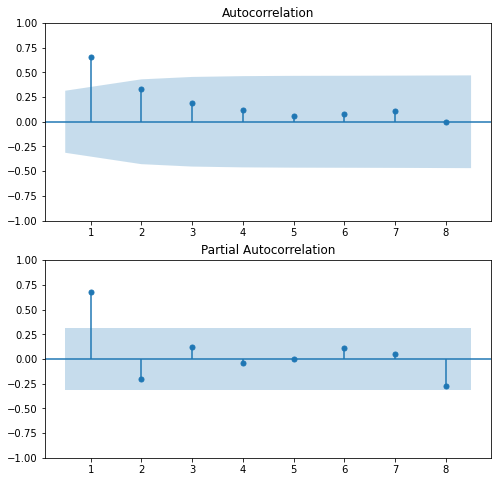

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(err2, lags = 8, zero = False, ax = ax[0]);
plot_pacf(err2, lags = 8, zero = False, ax = ax[1]);
plt.show()

In [16]:
print('Durbin Watson statistic:', durbin_watson(err2))

lmtest2, pval2, fval2, f_pval2 = acorr_breusch_godfrey(lm_progunlaw2, nlags = 1)
print('LM test =', lmtest2)
print('p-value =', pval2)

Durbin Watson statistic: 0.5510005610327039
LM test = 22.36391973044164
p-value = 2.255721473254096e-06


# ​​5.​​ Consider ​​running ​​a ​​time ​​series ​​regression ​​with ​​many ​​Xs ​​and ​​trend. ​​​​Interpret ​​that. Check VIF.¶

In [18]:
lm_progunlaw3 = smf.ols('progunlaw_pct ~ age + ba_pct + hapmar_pct + year', data = by_year_ts).fit()
lm_progunlaw3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gunlaw_pct   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     8.253
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           9.95e-05
Time:                        22:06:17   Log-Likelihood:                -93.074
No. Observations:                  38   AIC:                             196.1
Df Residuals:                      33   BIC:                             204.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.5501    528.511     -0.101      0.920   -1128.813    1021.713
age            1.8497      1.071      1.727      0.094      -0.330       4.029
ba_pct        -0.9287      0.464     -2.001      0.054      -1.873       0.015
hapmar_pct     0.0115      0.119      0.097      0.924      -0.231       0.254
year           0.0555      0.283      0.196      0.846      -0.521       0.632
==============================================================================
Omnibus:                        2.442   Durbin-Watson:                   0.600
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                1.520
Skew:                           0.223   Prob(JB):                        0.468
Kurtosis:                       2.127   Cond. No.                     2.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results show that only degree is negatively correlated with gunlaw scores, while other variables are positively correlated with gunlaw scores.

In [19]:
y, X = dmatrices('progunlaw_pct ~ age + ba_pct + hapmar_pct + year',
                 data = by_year_ts, return_type = 'dataframe')

vif = pd.DataFrame()
vif['VIR Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.iloc[1:]

,VIR Factor,features
1,5.316117,age
2,22.794244,ba_pct
3,4.573329,hapmar_pct
4,41.622933,year


# 6. Run a first-differenced time series regression. Interpret that.

In [20]:
by_yearFD = pd.DataFrame()

by_yearFD = by_year_ts[['progunlaw_pct', 'age', 'ba_pct', 'hapmar_pct']]
by_yearFD = by_yearFD.diff()

by_yearFD['year'] = by_year_ts['year']

In [21]:
lm_progunlaw4 = smf.ols('progunlaw_pct ~ ba_pct + year', data = by_yearFD).fit()
lm_progunlaw4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gunlaw_pct   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.448
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.101
Time:                        22:06:20   Log-Likelihood:                -67.462
No. Observations:                  38   AIC:                             140.9
Df Residuals:                      35   BIC:                             145.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.9454     43.395     -1.773      0.085    -165.042      11.151
ba_pct         0.2950      0.206      1.434      0.160      -0.123       0.713
year           0.0386      0.022      1.770      0.086      -0.006       0.083
==============================================================================
Omnibus:                        2.161   Durbin-Watson:                   1.308
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                1.260
Skew:                           0.418   Prob(JB):                        0.533
Kurtosis:                       3.310   Cond. No.                     3.58e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model showed that every time the degree increases by 1, the support to gun purchase restrictions rose by 0.3 points; it is statistically significant. The adjusted R-squared for this model is 0.073, which suggests that we can explain about 7% of the change in attitudes about gun restrictions with this model.

# 7. Check your variables for unit roots. Do some test. Interpret them.

In [22]:
ADF(by_year_ts['progunlaw_pct'], lags = int(4*(len(by_year_ts)/100)**(2/9)), trend = 'c')

Test Statistic,-1.204
P-value,0.672
Lags,3


In [23]:
DFGLS(by_year_ts['progunlaw_pct'], lags = int(4*(len(by_year_ts)/100)**(2/9)), trend = 'c')

Test Statistic,-1.099
P-value,0.254
Lags,3


In [24]:
PhillipsPerron(by_year_ts['progunlaw_pct'], lags = 3)

Test Statistic,-1.519
P-value,0.524
Lags,3


# 8. Perform an Automatic ARIMA on the residuals from one of your earlier models. Tell me what it says.¶

In [25]:
warnings.filterwarnings("ignore")

auto_arima(err2, trace = True, test = 'kpss', information_criterion = 'bic')

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=189.191, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=201.686, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=179.032, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=184.972, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=198.023, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=181.948, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=181.926, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=185.587, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=175.480, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=178.346, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=178.328, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=181.316, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=181.987, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.219 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# 9. Run an ARIMA that follows from Step 8. Interpret that, too.

In [26]:
by_year_ts['intercept'] = 1
arima_progunlaw = SARIMAX(endog = by_year_ts['progunlaw_pct'], order = (0, 0, 1), 
                      exog = by_year_ts[['ba_pct', 'year', 'intercept']]).fit(trend = 'nc')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28290D+00    |proj g|=  5.12208D+00

At iterate    5    f=  2.28251D+00    |proj g|=  8.29161D+00

At iterate   10    f=  2.26721D+00    |proj g|=  4.65530D+01

At iterate   15    f=  2.26124D+00    |proj g|=  2.04267D-01

At iterate   20    f=  2.24394D+00    |proj g|=  3.26631D+01

At iterate   25    f=  2.22334D+00    |proj g|=  8.86012D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     73      2     0     0   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [28]:
arima_progunlaw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             gunlaw_pct   No. Observations:                   39
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -86.683
Date:                Sun, 11 Dec 2022   AIC                            183.367
Time:                        22:18:21   BIC                            191.684
Sample:                             0   HQIC                           186.351
                                 - 39                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ba_pct        -1.0178      0.446     -2.281      0.023      -1.893      -0.143
year           0.2819      0.188      1.500      0.134      -0.086       0.650
intercept   -417.6581    365.378     -1.143      0.253   -1133.786     298.470
ma.L1          0.6700      0.148      4.524      0.000       0.380       0.960
sigma2         4.9139      1.462      3.361      0.001       2.049       7.779
===================================================================================
Ljung-Box (L1) (Q):                   2.81   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.09   Prob(JB):                         0.59
Heteroskedasticity (H):               1.14   Skew:                             0.40
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
acorr_ljungbox(arima_progunlaw.resid, boxpierce = True, lags = round((len(by_year_ts)/2-2), 0))

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.787568,0.094998,2.583599,0.107976
2,8.817771,0.012169,8.025490,0.018084
3,9.157019,0.027274,8.323366,0.039781
4,10.901502,0.027694,9.812560,0.043706
5,11.024850,0.050889,9.914848,0.077684
6,11.256928,0.080753,10.101642,0.120436
7,13.409599,0.062736,11.781776,0.107968
8,13.435510,0.097718,11.801367,0.160289
9,13.437977,0.143769,11.803172,0.224634
10,13.885276,0.178289,12.119554,0.277135
